model

In [1]:
import os
import random
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, precision_recall_curve, average_precision_score
import seaborn as sns

# Set random seed for reproducibility
seed = 42
np.random.seed(seed)

# Image dimensions and paths
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 1

# Updated paths
TRAIN_PATH = r'C:\Users\medicai\Desktop\orginal_mass_images\without_augmentaion\resize_512x512\train'
TEST_PATH = r'C:\Users\medicai\Desktop\orginal_mass_images\without_augmentaion\resize_512x512\test'

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Get train and test IDs
train_ids = [f.split('.')[0] for f in os.listdir(os.path.join(TRAIN_PATH, 'images')) if f.endswith('.png')]
test_ids = [f.split('.')[0] for f in os.listdir(os.path.join(TEST_PATH, 'images')) if f.endswith('.png')]

# Initialize arrays for images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

# Resizing training images and masks
print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + '/images/' + id_
    img = imread(path + '.png')
    
    if len(img.shape) == 2:  # Grayscale image
        img = np.expand_dims(img, axis=-1)
    
    X_train[n] = img
    
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    for mask_file in next(os.walk(TRAIN_PATH + '/masks/'))[2]:
        if mask_file.startswith(id_):
            mask_ = imread(TRAIN_PATH + '/masks/' + mask_file)
            mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
            mask = np.maximum(mask, mask_)
    
    Y_train[n] = mask

# Test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []

print('Resizing test images')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = os.path.join(TEST_PATH, 'images', id_)
    img = imread(path + '.png')
    
    if len(img.shape) == 2:
        img = np.expand_dims(img, axis=-1)
    
    sizes_test.append([img.shape[0], img.shape[1]])
    X_test[n] = img

# Model creation
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

# Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.01)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.01)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.02)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.02)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.03)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

# Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.02)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.02)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.01)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1])
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.01)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.summary()

# Custom IOU metric
def mean_iou(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersect = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32), axis=[1, 2, 3])
    union = tf.reduce_sum(tf.cast(y_true + y_pred, tf.float32), axis=[1, 2, 3]) - intersect
    iou = tf.where(union == 0, tf.ones_like(intersect), intersect / union)
    return tf.reduce_mean(iou)

# Custom Dice coefficient
def dice_coefficient(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersect = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32), axis=[1, 2, 3])
    denominator = tf.reduce_sum(tf.cast(y_true + y_pred, tf.float32), axis=[1, 2, 3])
    dice = (2 * intersect) / (denominator + tf.keras.backend.epsilon())
    return tf.reduce_mean(dice)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou, dice_coefficient])

# Image data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen_args = dict(rotation_range=10,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.1,
                     horizontal_flip=True,
                     fill_mode='nearest')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Split the data into training and validation sets manually
validation_split = 0.1
num_train_samples = int((1 - validation_split) * len(X_train))

X_train_sub, X_val = X_train[:num_train_samples], X_train[num_train_samples:]
Y_train_sub, Y_val = Y_train[:num_train_samples], Y_train[num_train_samples:]

# Training with data augmentation
batch_size = 8
train_image_generator = image_datagen.flow(X_train_sub, batch_size=batch_size, seed=seed)
train_mask_generator = mask_datagen.flow(Y_train_sub, batch_size=batch_size, seed=seed)
train_generator = zip(train_image_generator, train_mask_generator)

# Validation generator (without augmentation)
val_image_generator = ImageDataGenerator().flow(X_val, batch_size=batch_size, seed=seed)
val_mask_generator = ImageDataGenerator().flow(Y_val, batch_size=batch_size, seed=seed)
val_generator = zip(val_image_generator, val_mask_generator)

# Train the model
model.fit(train_generator, steps_per_epoch=len(X_train_sub) // batch_size, epochs=50, validation_data=val_generator, validation_steps=len(X_val) // batch_size)

# Save the model
model.save('unet_model_2_512.h5')

# Predictions
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Flatten Y_test and predictions for metrics calculation
Y_test_flatten = np.zeros_like(preds_test_t)  # Initialize Y_test_flatten if you have test masks
preds_test_flatten = preds_test_t.flatten()

# Calculate accuracy
accuracy = accuracy_score(Y_test_flatten.flatten(), preds_test_flatten)

# Calculate F1 score, precision, recall
precision, recall, f1, _ = precision_recall_fscore_support(Y_test_flatten.flatten(), preds_test_flatten, average='binary')

# Calculate mean IoU
iou = np.sum((Y_test_flatten.flatten() & preds_test_flatten)) / np.sum((Y_test_flatten.flatten() | preds_test_flatten))

# Calculate mean Dice coefficient
dice = (2 * np.sum((Y_test_flatten.flatten() & preds_test_flatten))) / (np.sum(Y_test_flatten.flatten()) + np.sum(preds_test_flatten))

# Calculate mAP@.50:.95
precision_curve, recall_curve, _ = precision_recall_curve(Y_test_flatten.flatten(), preds_test.flatten())
average_precision = average_precision_score(Y_test_flatten.flatten(), preds_test.flatten())

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"IoU: {iou:.4f}")
print(f"Dice Coefficient: {dice:.4f}")
print(f"mAP@.50:.95: {average_precision:.4f}")


2.10.1
Num GPUs Available:  4
Resizing training images and masks


100%|██████████| 2004/2004 [00:48<00:00, 41.50it/s]


Resizing test images


100%|██████████| 223/223 [00:00<00:00, 280.86it/s]


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 512, 512, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  160         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

c:\Users\medicai\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\medicai\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Accuracy: 0.9914
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
IoU: 0.0000
Dice Coefficient: 0.0000
mAP@.50:.95: -0.0000


c:\Users\medicai\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Ensure Test Masks are Loaded Correctly: It seems that the Y_test (test masks) are either missing or initialized as zeros, leading to the calculation errors. Make sure that you have actual test mask data corresponding to the test images, and initialize Y_test properly, just like you did with Y_train.

In [2]:
# Initialize arrays for test masks (assuming you have them)
Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

print('Resizing test images and masks')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = os.path.join(TEST_PATH, 'images', id_)
    img = imread(path + '.png')
    
    if len(img.shape) == 2:
        img = np.expand_dims(img, axis=-1)
    
    sizes_test.append([img.shape[0], img.shape[1]])
    X_test[n] = img

    # Load corresponding mask if available
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    for mask_file in next(os.walk(TEST_PATH + '/masks/'))[2]:
        if mask_file.startswith(id_):
            mask_ = imread(TEST_PATH + '/masks/' + mask_file)
            mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
            mask = np.maximum(mask, mask_)
    
    Y_test[n] = mask


Resizing test images and masks


100%|██████████| 223/223 [00:03<00:00, 57.81it/s]


Metrics Calculation

In [4]:
# Flatten Y_test and predictions for metrics calculation
Y_test_flatten = Y_test.flatten()
preds_test_flatten = preds_test_t.flatten()

# Calculate accuracy
accuracy = accuracy_score(Y_test_flatten, preds_test_flatten)

# Calculate precision, recall, F1 score
precision, recall, f1, _ = precision_recall_fscore_support(Y_test_flatten, preds_test_flatten, average='binary')

# Calculate mean IoU
iou = np.sum((Y_test_flatten & preds_test_flatten)) / np.sum((Y_test_flatten | preds_test_flatten))

# Calculate mean Dice coefficient
dice = (2 * np.sum((Y_test_flatten & preds_test_flatten))) / (np.sum(Y_test_flatten) + np.sum(preds_test_flatten))

# Calculate mAP@.50:.95
precision_curve, recall_curve, _ = precision_recall_curve(Y_test_flatten, preds_test.flatten())
average_precision = average_precision_score(Y_test_flatten, preds_test.flatten())

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"IoU: {iou:.4f}")
print(f"Dice Coefficient: {dice:.4f}")
print(f"mAP@.50:.95: {average_precision:.4f}")


Accuracy: 0.9929
Precision: 0.8504
Recall: 0.5543
F1 Score: 0.6711
IoU: 0.5051
Dice Coefficient: 0.6711
mAP@.50:.95: 0.7683


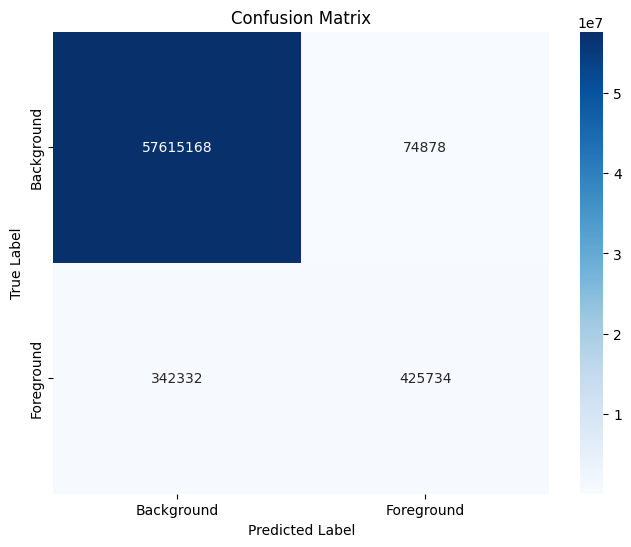

In [5]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Flatten the true masks and predictions
Y_test_flatten = Y_test.flatten()
preds_test_flatten = preds_test_t.flatten()

# Calculate the confusion matrix
cm = confusion_matrix(Y_test_flatten, preds_test_flatten)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Background', 'Foreground'], yticklabels=['Background', 'Foreground'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


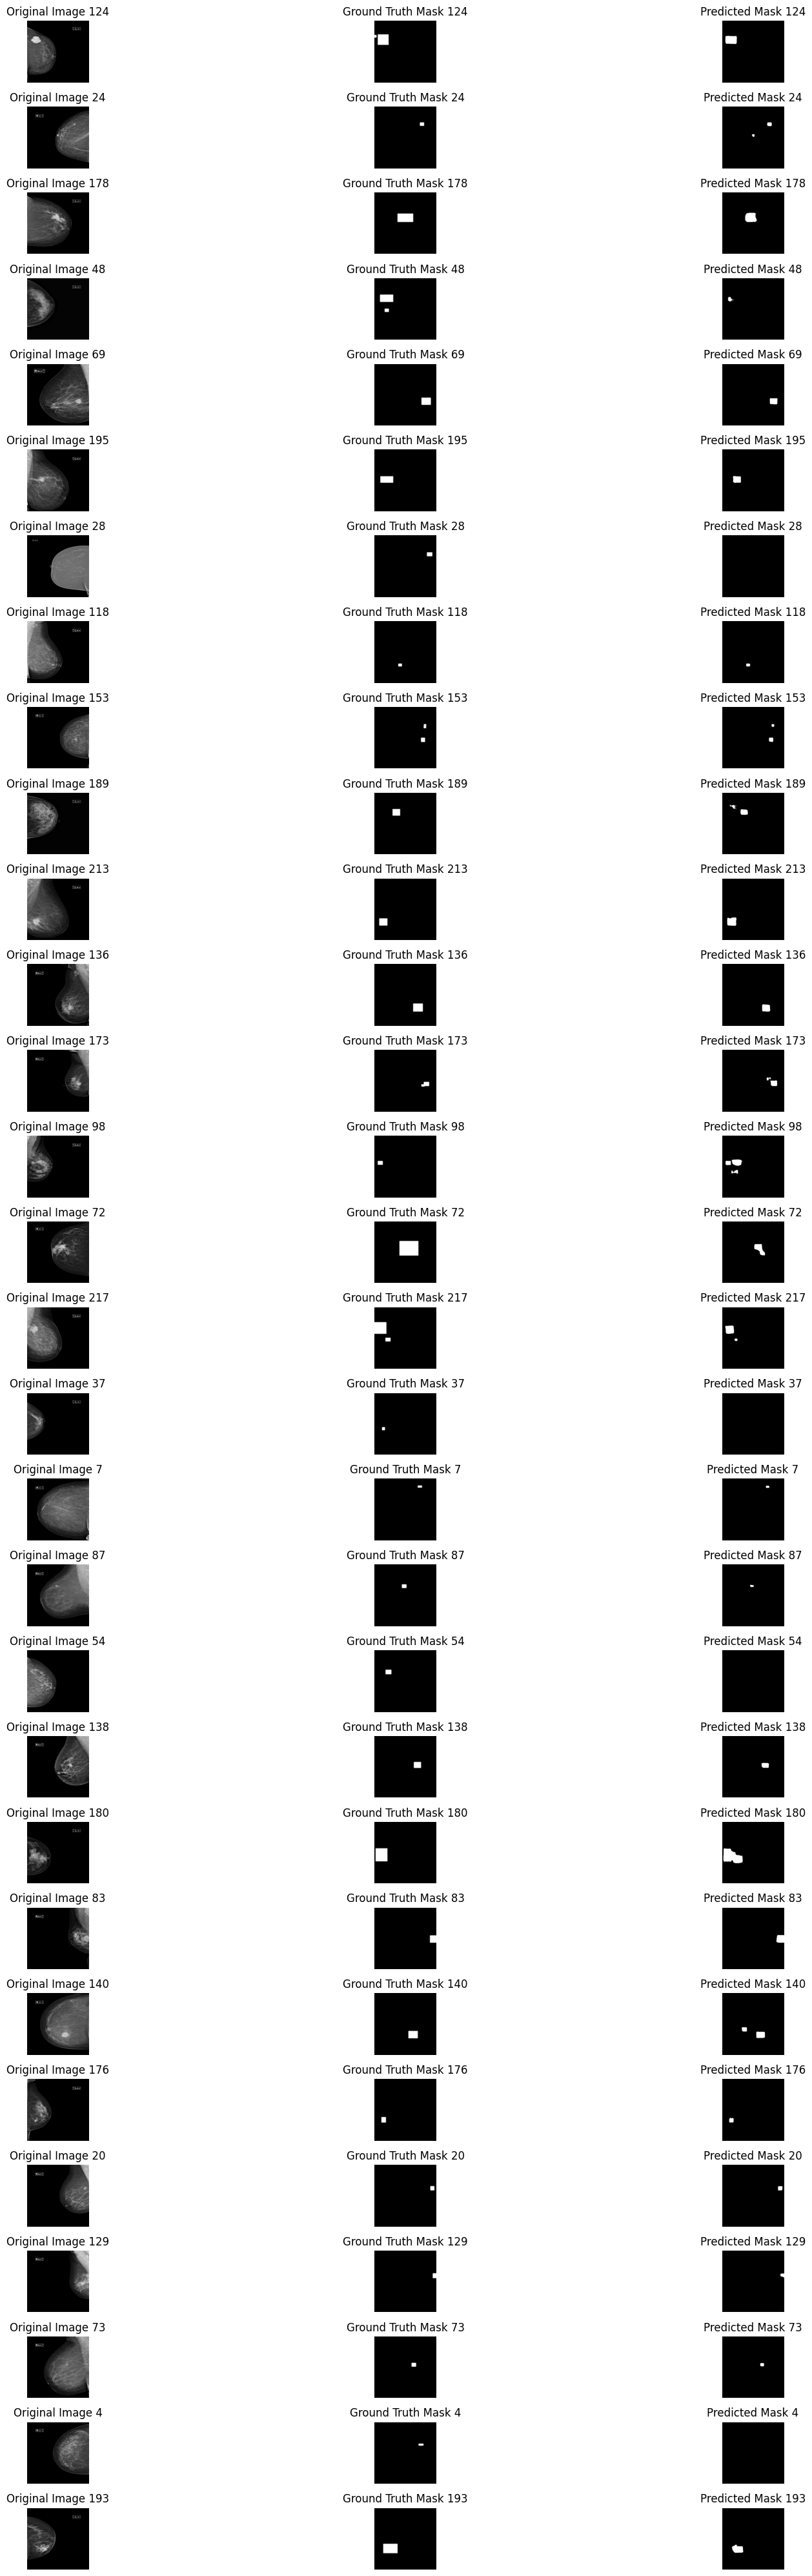

In [6]:
import matplotlib.pyplot as plt

# Number of images to display
num_images = 30

# Select random indices to display
random_indices = np.random.choice(len(X_test), num_images, replace=False)

# Set the figure size and increase the spacing between images
plt.figure(figsize=(20, 40))

for i, idx in enumerate(random_indices):
    # Original image
    original_image = X_test[idx].squeeze()  # Remove channel dimension if present

    # Ground truth mask
    ground_truth_mask = Y_test[idx].squeeze()

    # Predicted mask
    predicted_mask = preds_test_t[idx].squeeze()

    # Plot original image
    plt.subplot(num_images, 3, 3 * i + 1)
    plt.imshow(original_image, cmap='gray')
    plt.title(f"Original Image {idx}")
    plt.axis('off')

    # Plot ground truth mask
    plt.subplot(num_images, 3, 3 * i + 2)
    plt.imshow(ground_truth_mask, cmap='gray')
    plt.title(f"Ground Truth Mask {idx}")
    plt.axis('off')

    # Plot predicted mask
    plt.subplot(num_images, 3, 3 * i + 3)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title(f"Predicted Mask {idx}")
    plt.axis('off')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()
